<hr size="5" />

### **<font color='DarkCyan'>Salzburg University of Applied Sciences - 2023**  
#### **<font color='DarkCyan'>Information Technology & Systems Engineering**

# **<font color='GoldenRod'>Master Thesis**  
## **<font color='GoldenRod'>Deep Learning for Advancing Animal Breeding: A Study on Austrian Fleckvieh Cattle**

<hr size="5">

#### Student Name: Jakob Ganitzer
#### Degree Program:  ITSM-B

<hr size="5" />

### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from models.megaencoder import MegaChunkRegressor_MLP_cat_Reduced
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import mean_squared_error 
import cairosvg

In [2]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)

In [3]:
criterion = nn.MSELoss()

### Load Data

In [4]:
dataRoot = "/data"
wandbDir = "/data"
eval_dataframes = '/eval_dataframes/mega/'

In [5]:
heritability = "/h40"
phenotype_path = dataRoot + heritability + heritability + "_simu.dat"
snp_path = dataRoot + heritability + heritability + "_simu.snp"
benchmark_path = dataRoot + heritability + heritability + "_simu.bv"
pedigree_path = dataRoot + heritability + heritability + "_simu.ped"
snpPos_path = dataRoot + heritability + heritability + "_simu_snp.txt"
qtl_path = dataRoot + heritability + heritability + "_simu_qtl.txt"

In [6]:
checkpointRoot = '/data/checkpoints/'

In [7]:
df_dam30F = pd.read_parquet(dataRoot + heritability + '/dam30F.parquet', engine='pyarrow')

In [8]:
modelName = 'MLP_MegaChunk_maf'

In [9]:
heritability = "/h40"

X_path = "/test/snp_X_test_01_maf_one_hot.parquet"

y_path = "/test/snp_y_test_01_maf_one_hot.parquet"

#gen30

X_path = "/test/snpGen30_X_test_01.parquet"

y_path = "/test/snpGen30_y_test_01.parquet"


####
testPath = '/snpTruePheno_gen30_BPpos_maf.parquet'

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
def add_value(x, value):
    return x + value

class CatTestMaskLoaderfine:
    def __init__(self, dataRoot, trainPath, testPath,wandbDir, batch_size = 16,  paddedLength = -1):
        self.dataRoot = dataRoot
        self.trainPath = trainPath
        self.testPath = testPath
        self.batch_size = batch_size
        self.wandbDir = wandbDir
        self.paddedLength = paddedLength

    def getLoaders(self, addValue = 0):

        df_snp_pheno_train = pd.read_parquet(self.dataRoot + self.trainPath, engine='pyarrow')
        df_snp_pheno_test = pd.read_parquet(self.dataRoot + self.testPath, engine='pyarrow')

        X_train_df = df_snp_pheno_train.drop(columns=['phenotype', 'id'], axis=1)
        X_val_df = df_snp_pheno_test.drop(columns=['phenotype', 'id'], axis=1)
        y_train = df_snp_pheno_train["phenotype"]
        y_val = df_snp_pheno_test["phenotype"]
        
        id_val = df_snp_pheno_test["id"]
        id_train = df_snp_pheno_train["id"]
        
        X_train_df = X_train_df.apply(add_value, value=addValue)
        X_val_df = X_val_df.apply(add_value, value=addValue)
        
        # Create attention_mask (torch.FloatTensor of shape (batch_size, sequence_length)) for train and val
        attention_mask_train = torch.ones(X_train_df.shape[0], X_train_df.shape[1]).to('cpu')
        attention_mask_val = torch.ones(X_val_df.shape[0], X_val_df.shape[1]).to('cpu')

        if self.paddedLength != -1 and self.paddedLength > X_train_df.shape[1]:
            pad = self.paddedLength - X_train_df.shape[1]
            
            # Add column names to the padded data frames
            new_columns = list(X_train_df.columns) + ['pad_' + str(i) for i in range(pad)]
            
            # Pad the data to the max length
            X_train_df = pd.DataFrame(np.pad(X_train_df.values, ((0, 0), (0, pad)), 'constant', constant_values=3), columns = new_columns)
            X_val_df = pd.DataFrame(np.pad(X_val_df.values, ((0, 0), (0, pad)), 'constant', constant_values=3), columns = new_columns)

            attention_mask_train = F.pad(attention_mask_train, (0, pad), 'constant', 0)
            attention_mask_val = F.pad(attention_mask_val, (0, pad), 'constant', 0)
        
        X_train_tensor = torch.tensor(X_train_df.to_numpy(), dtype=torch.int8).to('cpu')
        X_val_tensor = torch.tensor(X_val_df.to_numpy(), dtype=torch.int8).to('cpu')

        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to('cpu')
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to('cpu')

        id_val_tensor = torch.tensor(id_val.values, dtype=torch.int).to('cpu')
        id_train_tensor = torch.tensor(id_train.values, dtype=torch.int).to('cpu')
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, attention_mask_train, id_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor, attention_mask_val, id_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory = True, num_workers = 2)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory = True, num_workers = 2)

        return val_loader, train_loader
    
class OneTestHotMaskLoaderFine:
    def __init__(self, dataRoot, trainPath, testPath,wandbDir, batch_size = 16, paddedLength = -1):
        self.dataRoot = dataRoot
        self.trainPath = trainPath
        self.testPath = testPath
        self.batch_size = batch_size
        self.wandbDir = wandbDir
        self.paddedLength = paddedLength
        
    def getLoaders(self):
        
        df_snp_pheno_train = pd.read_parquet(self.dataRoot + self.trainPath, engine='pyarrow')
        df_snp_pheno_test = pd.read_parquet(self.dataRoot + self.testPath, engine='pyarrow')

        X_train_df = df_snp_pheno_train.drop(columns=['phenotype', 'id'], axis=1)
        X_val_df = df_snp_pheno_test.drop(columns=['phenotype', 'id', 'sire', 'dam'], axis=1) #remove on NEW
                
        y_train = df_snp_pheno_train["phenotype"]
        y_val = df_snp_pheno_test["phenotype"]
        
        id_val = df_snp_pheno_test["id"]
        id_train = df_snp_pheno_train["id"]
                      
        X_train = X_train_df.to_numpy()
        X_val = X_val_df.to_numpy()

        # Reshape the data back to its original shape
        X_train = X_train.reshape(X_train_df.shape[0], int(X_train_df.shape[1]/3), 3)
        X_val = X_val.reshape(X_val_df.shape[0], int(X_val_df.shape[1]/3), 3)
        
        # Create attention_mask (torch.FloatTensor of shape (batch_size, sequence_length)) for train and val
        attention_mask_train = torch.ones(X_train.shape[0], X_train.shape[1]).to('cpu')
        attention_mask_val = torch.ones(X_val.shape[0], X_val.shape[1]).to('cpu')

        if(self.paddedLength != -1 and self.paddedLength > X_train.shape[1]):
            pad = self.paddedLength - X_train.shape[1]
            # Pad the data to the max length
            X_train = np.pad(X_train, ((0,0),(0,pad),(0,0)), 'constant', constant_values=0)
            X_val = np.pad(X_val, ((0,0),(0,pad),(0,0)), 'constant', constant_values=0)
            attention_mask_train = F.pad(attention_mask_train, (0,pad), 'constant', 0)
            attention_mask_val = F.pad(attention_mask_val, (0,pad), 'constant', 0)
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to('cpu')
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to('cpu')

        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to('cpu')
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to('cpu')

        id_val_tensor = torch.tensor(id_val.values, dtype=torch.int).to('cpu')
        id_train_tensor = torch.tensor(id_train.values, dtype=torch.int).to('cpu')
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor, attention_mask_train, id_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor, attention_mask_val, id_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory = True,num_workers = 2)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory = True, num_workers = 2)

        return val_loader, train_loader

In [12]:
def loadAndCheckModel():
    # Load the saved checkpoint
    checkpoint = torch.load(checkpointRoot + modelName + '/best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

In [13]:
def evaluate():
    inference_df = pd.DataFrame(columns=['targets', 'output'])
    dtype1 = torch.cuda.IntTensor
    dtype2 = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets, attention_mask_val, ids in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype1)
                targets = targets.to(device).type(dtype2)
                attention_mask_val = attention_mask_val.to(device).type(torch.cuda.IntTensor)
                ids = ids.to(device).type(dtype1)

                output, pooled_output, embedding = model(data, attention_mask_val)

                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')
                ids_np = ids.cpu().numpy().astype('int')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np,
                    'id': ids_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)
                pooled_output_np = pooled_output.cpu().numpy().astype('float32')
                temp_df = pd.DataFrame(pooled_output_np, columns=[f'snp_{i}' for i in range(pooled_output_np.shape[1])])
                dfs.append(temp_df)

    df_pooled_output = pd.concat(dfs, ignore_index=True, axis=0)
    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets, df_pooled_output

def evaluateOneHot():
    inference_df = pd.DataFrame(columns=['targets', 'output'])
    dtype = torch.cuda.FloatTensor

    dfs = []

    with torch.no_grad():
        for data, targets, attention_mask_val, ids in val_loader:
            with torch.cuda.amp.autocast():
                data = data.to(device).type(dtype)
                targets = targets.to(device).type(dtype)
                attention_mask_val = attention_mask_val.to(device).type(torch.cuda.IntTensor)
                ids = ids.to(device).type(dtype)

                output, pooled_output, embedding = model(data, attention_mask_val)

                targets_np = targets.cpu().numpy()
                output_np = output.cpu().numpy().astype('float32')
                ids_np = ids.cpu().numpy().astype('int')

                temp_df = pd.DataFrame({
                    'targets': targets_np,
                    'output': output_np,
                    'id': ids_np
                })

                inference_df = pd.concat([inference_df, temp_df], ignore_index=True)
                pooled_output_np = pooled_output.cpu().numpy().astype('float32')
                temp_df = pd.DataFrame(pooled_output_np, columns=[f'snp_{i}' for i in range(pooled_output_np.shape[1])])
                dfs.append(temp_df)

    df_pooled_output = pd.concat(dfs, ignore_index=True, axis=0)
    targets = torch.tensor(inference_df['targets'].values).to(device)
    output = torch.tensor(inference_df['output'].values).to(device)
    
    return inference_df, output, targets, df_pooled_output

In [14]:
def createDataframeAndSave(inference_df, df_pooled_output, hasId = True):
    combined_df = pd.concat([inference_df, df_pooled_output], axis=1)
    if hasId == True : combined_df['id'] = combined_df['id'].astype(int)
    combined_df.to_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet')

In [15]:
def calcMetrics(output, targets):
    mse = mean_squared_error(output, targets)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets- output) / targets)) * 100
    mbe = np.mean(targets - output)
    
    print("MSE:", mse)
    print("Mean Absolute Error:", mae)
    print("R2 Score:", r2)
    print("Pearson Correlation Coefficient:", _pearsonr)
    print("p-value:", _pvalue)
    print("rmse:", rmse)
    print("mape:", mape)
    print("mbe:", mbe)

In [16]:
def stratifiedMetrics(output, targets, num_bins=3):
    # Determine bin edges
    bin_edges = np.linspace(min(targets), max(targets), num_bins+1)
    
    for i in range(num_bins):
        # Select data within the bin
        mask = (targets >= bin_edges[i]) & (targets < bin_edges[i+1])
        targets_bin = targets[mask]
        output_bin = output[mask]
        
        # Print value range of the bin
        bin_range = f"{bin_edges[i]} - {bin_edges[i+1]}"
        print(f"\nValue Range for Bin {i+1}: {bin_range}")

        mae = mean_absolute_error(targets_bin, output_bin)
        
        print("Mean Absolute Error:", mae)

In [17]:
def createScatterPlot(inference_df, imageName):
    fig, ax = plt.subplots(figsize=(5, 5)) 

    sns.regplot(data=inference_df, x="output", y="targets", ax=ax, color='darkblue',line_kws={"color": "red"}, scatter = True, scatter_kws={'s':3, 'rasterized': True})

    # Calculate slope and intercept
    slope, intercept = np.polyfit(inference_df["output"], inference_df["targets"], 1)
    line = f"TBV = {intercept:.4f} + {slope:.4f} x EBV"  # Equation of the line

    # Plot slope and intercept
    ax.text(0.05, 0.90, line, transform=ax.transAxes, va="top", fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.axline((9.8, 9.8), slope=1, color='black', linestyle='--') 
    
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel("EBV", fontsize=12)
    ax.set_ylabel("TBV", fontsize=12)
    
    ax.set_xlim(9.5, 16.5) 
    ax.set_ylim(9.5, 16.5) 
    
    plt.savefig('images/corr_' + imageName + '.png')
    plt.savefig('images/corr_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/corr_' + imageName + '.svg', write_to='images/corr_' + imageName + '.pdf')
    plt.savefig('images/corr_' + imageName + '.eps', format='eps')
    
    plt.show()  


In [18]:
def loadEvalData(modelName):
    model_data = pd.read_parquet(dataRoot + heritability + eval_dataframes + modelName + '.parquet', engine='pyarrow')
    
    output_data = model_data['output'].values.astype(float)
    target_data = model_data['targets'].values.astype(float)
    output = torch.Tensor(output_data)
    targets = torch.Tensor(target_data)
    return model_data[['output', 'targets']],output_data, target_data, model_data

In [19]:
sns.set_style("darkgrid")
sns.set_context("paper")

def plot_histograms(output, targets, imageName):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(output, ax=axs[0], kde=True)
    sns.histplot(targets, ax=axs[1], color='mediumseagreen', kde=True)

    # Calculate mean and standard deviation
    output_mean = np.mean(output)
    output_std = np.std(output)
    targets_mean = np.mean(targets)
    targets_std = np.std(targets)

    # Add mean and standard deviation as text annotations
    axs[0].text(0.05, 0.9, f'Mean: {output_mean:.2f}\nSD: {output_std:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axs[1].text(0.05, 0.9, f'Mean: {targets_mean:.2f}\nSD: {targets_std:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    # Add lines for mean
    axs[0].axvline(output_mean, color='red', linestyle='dashed', linewidth=1)
    axs[1].axvline(targets_mean, color='red', linestyle='dashed', linewidth=1)

    # Overlay histograms using Seaborn
    sns.histplot(output, ax=axs[2],  kde=True, label='EBV', element='step')
    sns.histplot(targets, ax=axs[2], color='mediumseagreen', kde=True, label='TBV', element='step')

    axs[0].tick_params(axis='both', which='major', labelsize=12) 
    axs[0].set_xlabel('Estimated Breeding Values', fontsize=14) 
    axs[0].set_ylabel('Count', fontsize=14)
    axs[0].set_title('EBV Distribution', fontsize=16)  

    axs[1].tick_params(axis='both', which='major', labelsize=12) 
    axs[1].set_xlabel('True Breeding Values', fontsize=14)
    axs[1].set_ylabel('Count', fontsize=14)
    axs[1].set_title('TBV Distribution', fontsize=16)

    axs[2].tick_params(axis='both', which='major', labelsize=12) 
    axs[2].set_xlabel('Values', fontsize=14)
    axs[2].set_ylabel('Count', fontsize=14)
    axs[2].set_title('Overlayed EBV and TBV Distributions', fontsize=16)

    axs[2].legend()

    plt.tight_layout()
    plt.savefig('images/dist_' + imageName + '.png')
    plt.savefig('images/dist_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/dist_' + imageName + '.svg', write_to='images/dist_' + imageName + '.pdf')
    plt.savefig('images/dist_' + imageName + '.eps', format='eps')
    plt.show()


In [20]:
def plot_residuals(output_np, targets_np, imageName):
    # Calculate residuals
    residuals = targets_np - output_np
    fig, ax = plt.subplots(figsize=(5,4))

    sns.regplot(x=output_np, y=residuals, scatter=True, ax=ax, line_kws=dict(color="r"), color='darkblue', scatter_kws={'s':3, 'rasterized': True})

    ax.axhline(y=0, color='black', linestyle='--') 
    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)

    ax.set_xlim(9.5, 16.5)
    ax.set_ylim(-1.7, 1.7)
    
    plt.tight_layout()
    
    plt.savefig('images/resid_' + imageName + '.png')
    plt.savefig('images/resid_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/resid_' + imageName + '.svg', write_to='images/resid_' + imageName + '.pdf')
    plt.savefig('images/resid_' + imageName + '.eps', format='eps')
    plt.show()

In [21]:
data = ['ModelName','MSE', 'MAE', 'R2', 'PearsonR']
df_metrics = pd.DataFrame(columns = data)

def calcMetricsStore(output, targets, modelName):
    mse = mean_squared_error(targets, output)
    mae = mean_absolute_error(targets, output)
    r2 = r2_score(targets, output)
    _pearsonr, _pvalue = pearsonr(targets, output)

    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((targets - output) / targets)) * 100
    mbe = np.mean(targets - output)

    new_data = {
        'ModelName': modelName,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'PearsonR': _pearsonr,
    }

    df = pd.DataFrame([new_data])

    return df

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import matplotlib.ticker as ticker

def plot_wandering_schemantic(output_np, targets_np, imageName):
    
    # Set seaborn style
    sns.set(style="dark")

    sns.set_context("paper")

    residuals = targets_np - output_np
    y_values = residuals
    x_values = output_np

    n_samples = len(x_values)

    quantiles = np.power(2, -np.arange(2, np.floor(np.log(n_samples/10)/np.log(2))+1))
    quantiles = np.concatenate((np.flip(quantiles), np.array([1/2]), 1- quantiles))
    n_bins = len(quantiles) + 1
    bins = pd.cut(x_values, np.quantile(x_values, np.concatenate(([0],  quantiles, [1]))), duplicates='drop')

    x_series = pd.Series(x_values)
    bin_medians = x_series.groupby(bins).median()
    bin_counts  = x_series.groupby(bins).size()
    max_bin_count = bin_counts.max()
    x_range = np.ptp(x_series)

    fig, ax = plt.subplots(figsize=(5, 4)) 
    plt.scatter(x_values, y_values, s= 3,   color = 'darkblue', rasterized = True)

    # Store median, 1st, 5th, 25th, 75th, 95th, and 99th percentile positions for connecting lines
    median_positions = []
    q1_positions = []
    q5_positions = []
    q25_positions = []
    q75_positions = []
    q95_positions = []
    q99_positions = []
    q50_positions = []

    # Calculate the positions for boxplots based on bin medians
    for i, median in enumerate(bin_medians):
        # Get the y_values within the current bin
        current_bin_y = y_values[bins.codes == i]
        print()
        # Calculate the position for the boxplot based on the bin median
        boxplot_position = median
        median_positions.append(boxplot_position)

        # Calculate percentiles if the bin is not empty
        if len(current_bin_y) > 0:
            q1_positions.append(np.percentile(current_bin_y, 1))
            q5_positions.append(np.percentile(current_bin_y, 5))
            q25_positions.append(np.percentile(current_bin_y, 25))
            q75_positions.append(np.percentile(current_bin_y, 75))
            q95_positions.append(np.percentile(current_bin_y, 95))
            q99_positions.append(np.percentile(current_bin_y, 99))
            q50_positions.append(np.percentile(current_bin_y, 50))
        else:
            q1_positions.append(np.nan)
            q5_positions.append(np.nan)
            q25_positions.append(np.nan)
            q75_positions.append(np.nan)
            q95_positions.append(np.nan)
            q99_positions.append(np.nan)
            q50_positions.append(np.nan)

    coolwarm = plt.cm.viridis

    plt.plot(median_positions, q99_positions, color=coolwarm(0.95),linewidth=1.5, label='99% Percentile')  # 95% into the colormap
    plt.plot(median_positions, q95_positions, color=coolwarm(0.85),linewidth=1.5, label='95% Percentile')  # 85% into the colormap
    plt.plot(median_positions, q75_positions, color=coolwarm(0.65),linewidth=1.5, label='75% Quantile')  # 65% into the colormap
    plt.plot(median_positions, q50_positions, color=coolwarm(0.5), linewidth=1.5,label='Median')  # 50% into the colormap
    plt.plot(median_positions, q25_positions, color=coolwarm(0.5), linewidth=1.5,label='25% Quantile')  # 50% into the colormap
    plt.plot(median_positions, q5_positions, color=coolwarm(0.35), linewidth=1.5,label='5% Percentile')  # 35% into the colormap
    plt.plot(median_positions, q1_positions, color=coolwarm(0.15), linewidth=1.5, label='1% Percentile')  # 15% into the colormap

    intervals = bin_medians.index

    unique_values = set() 

    for interval in intervals:
        unique_values.add(interval.left)
        unique_values.add(interval.right)

    unique_values_array = np.array(list(unique_values)) 

    # Loop through unique values and plot vertical lines
    for value in unique_values_array:
        plt.axvline(x=value,  linewidth=1, color='gray', alpha=0.7)  

    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=3, title=None, frameon=False, fontsize='9')

    ax.tick_params(axis='both', which='major', labelsize=10) 
    ax.set_xlabel('EBV', fontsize=12)
    ax.set_ylabel('Residuals',  fontsize=12)


    sns.despine(left=True)
    plt.grid(axis='y')  
    plt.tight_layout()

    plt.savefig('images/wsp_' + imageName + '.png')
    plt.savefig('images/wsp_' + imageName + '.svg', format='svg', dpi=300)
    cairosvg.svg2pdf(url='images/wsp_' + imageName + '.svg', write_to='images/wsp_' + imageName + '.pdf')
    plt.savefig('images/wsp_' + imageName + '.eps', format='eps')
    plt.show()

## MEGA Inference

In [30]:
modelName = 'MLP_MegaChunk' 

In [ ]:
#Mega Config
paddedLength = 26624
max_pos = 27000
chunk_size = 2048 

batch_size = 64 

input_dim = 8 
num_layers = 2
num_heads = 1

hidden1 = 1000 
hidden2 = 500  
hidden3 = 200

In [ ]:
trainPath = '/snp_pheno_BPpos_maf.parquet'
testPath = '/snpTruePheno_gen30_BPpos_maf.parquet'

catLoader = CatTestMaskLoaderfine(dataRoot + heritability,trainPath, testPath, wandbDir=wandbDir, batch_size = batch_size, paddedLength = paddedLength)
val_loader, train_loader = catLoader.getLoaders(addValue = 7)
num_features = val_loader.dataset.tensors[0].shape[1] 

In [ ]:
model = MegaChunkRegressor_MLP_cat_Reduced(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, max_pos=max_pos, hidden1 = hidden1, hidden2 = hidden2, hidden3 = hidden3, num_features = num_features, chunk_size=chunk_size).to(device)
loadAndCheckModel()

inference_df, output, targets, df_pooled_output = evaluate()
output_np = output.cpu().numpy()
targets_np = targets.cpu().numpy()

#createDataframeAndSave(inference_df, df_pooled_output)

In [32]:
inference_df, output_np, targets_np, model_data = loadEvalData(modelName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


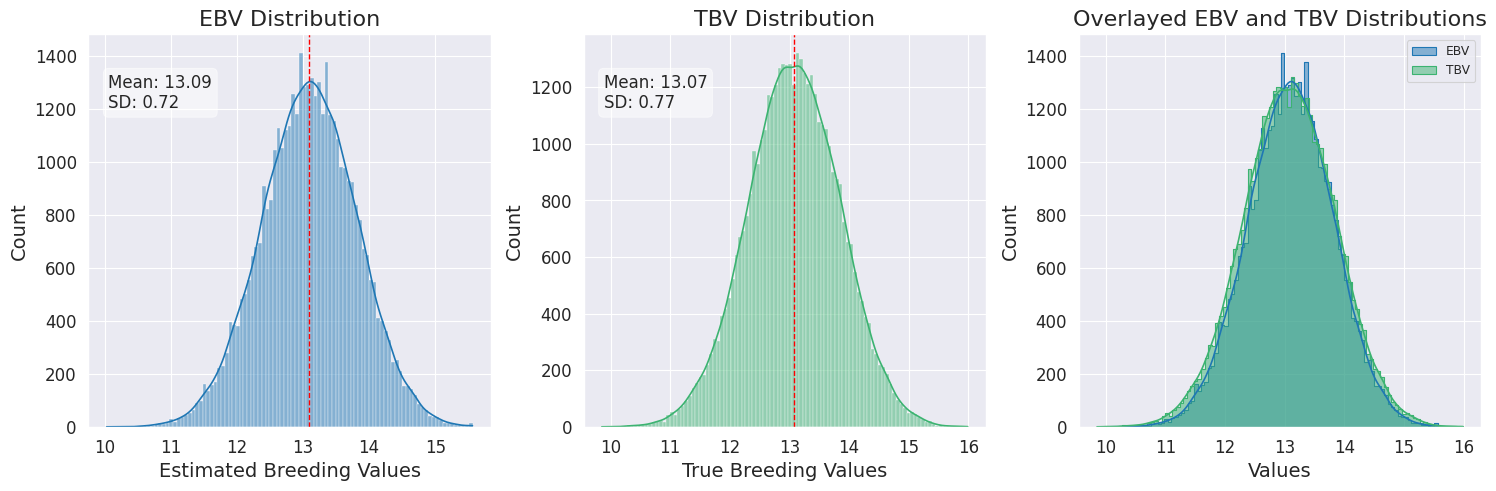

In [33]:
plot_histograms(output_np, targets_np, 'Mega_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


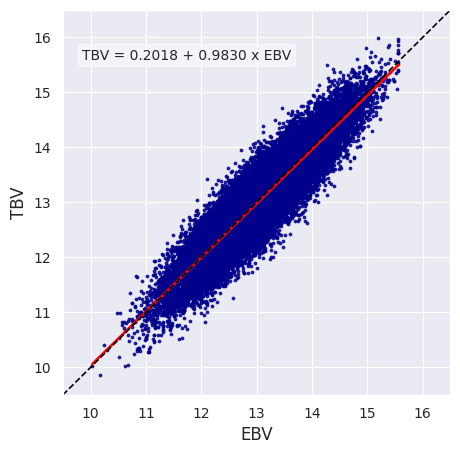

In [34]:
createScatterPlot(inference_df, 'Mega_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


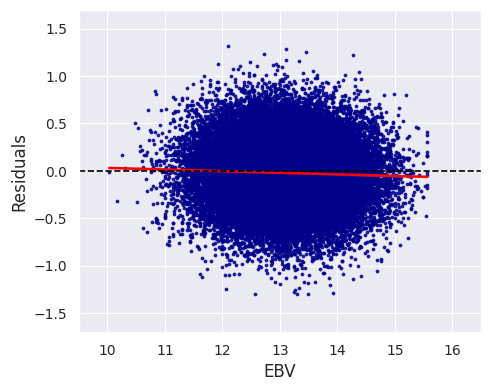

In [35]:
plot_residuals(output_np, targets_np, 'Mega_r_lt')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


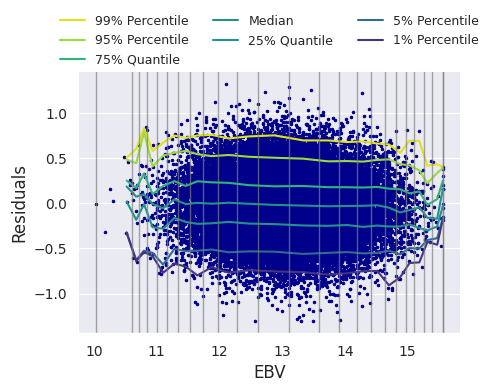

In [39]:
plot_wandering_schemantic(output_np, targets_np, 'Mega_r_lt')

In [36]:
stratifiedMetrics(output_np, targets_np, 5)


Value Range for Bin 1: 9.853228569030762 - 11.0800350189209
Mean Absolute Error: 0.4007026381411795

Value Range for Bin 2: 11.0800350189209 - 12.306841468811035
Mean Absolute Error: 0.29394492219940876

Value Range for Bin 3: 12.306841468811035 - 13.533647918701172
Mean Absolute Error: 0.24042142485957566

Value Range for Bin 4: 13.533647918701172 - 14.760454368591308
Mean Absolute Error: 0.2537561390610453

Value Range for Bin 5: 14.760454368591308 - 15.987260818481445
Mean Absolute Error: 0.3290566310981395


In [37]:
calcMetrics(output_np, targets_np)

MSE: 0.10204603201548683
Mean Absolute Error: 0.2543252889315287
R2 Score: 0.8298428201548848
Pearson Correlation Coefficient: 0.9115090009460555
p-value: 0.0
rmse: 0.31944644624019036
mape: 1.957558026993362
mbe: -0.021297532558441162
